In [1]:
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import RMSF
from MDAnalysis.analysis.rms import rmsd
from glob import glob
import itertools

In [48]:
def calc_rmsd(input_rec, debug=False, write=True):

    # Load reference structure
    u_ref = mda.Universe(input_rec["ref_PDB"])
    target_ref = u_ref.select_atoms(input_rec["ref_target"])

    # Get ubiquitine atom groups|
    ub_refs = []
    for key in list(input_rec.keys()):
        if "ref_Ub" in key:
            ub_refs.append(u_ref.select_atoms(input_rec[key]))

    # Here, we support 2 Ub
    model_names = glob(input_rec["model_PDBs"])[:10]

    # Load model structure
    u_model = mda.Universe(
              *model_names,
              all_coordinates = True,  # To use also the first frame.
              in_memory = True,
    )
    target_model = u_model.select_atoms(input_rec["model_target"])
    ub1_model    = u_model.select_atoms(input_rec["model_Ub1"])
    ub2_model    = u_model.select_atoms(input_rec["model_Ub2"])

    # Print summary
    if debug:
        print (" Ref. Target: ", target_ref.n_atoms)
        print (" Mod. Target: ", target_model.n_atoms)
        print (" Ref. Ub1: ", ub_refs[0].n_atoms)
        print (" Mod. Ub1: ", ub1_model.n_atoms)
        print (" Ref. Ub2: ", ub_refs[1].n_atoms)
        print (" Mod. Ub2: ", ub2_model.n_atoms)

    # Store results
    all_target_rmsd = np.zeros(len(model_names))
    all_ub_rmsd     = np.zeros((len(model_names), 2))

    for ts in u_model.trajectory:
        # Align target in model onto target in reference
        # Step 1: Align target_model onto target_ref
        align.alignto(target_model, target_ref, select="all", match_atoms=False)
        # Step 2: Align u_model onto target_model
        align.alignto(u_model, target_model, select=input_rec["model_target"], match_atoms=False)
        # Compute RMSDs
        #  i) target vs target
        target_rmsd = rmsd(target_model.positions, target_ref.positions, center=False, superposition=False)
        # ii) Compare all model Ubs vs all ref Ubs
        ub_comb_rmsds = []
        for ub_ref in ub_refs:
            for model_ub in ub1_model, ub2_model:
                value = rmsd(model_ub.positions, ub_ref.positions, center=False, superposition=False)
                ub_comb_rmsds.append(value)
        
        if False:
            #
            # Physically correct combination of two RMSD values, each having the same number of atoms:
            #
            # Because of the permutations, either take [0,3] or [1,2] as the respective RMSDs
            # We combine the two RMSDs:
            #    R_A = sqrt( 1/n * sum_A (x_i-x_i0)^2 ) 
            #    R_B = sqrt( 1/n * sum_B (x_i-x_i0)^2 )
            #    R_AB = sqrt( 1/2n * sum_AB (x_i-x_i0)^2 ) = sqrt (R_A^2 + R_B^2) / 2.0
            ub_rmsd_1 = np.sqrt(ub_comb_rmsds[0]**2 + ub_comb_rmsds[3]**2) / np.sqrt(2.0)
            ub_rmsd_2 = np.sqrt(ub_comb_rmsds[1]**2 + ub_comb_rmsds[2]**2) / np.sqrt(2.0)
            if ub_rmsd_1 < ub_rmsd_2:
                ub_rmsd = [ub_comb_rmsds[0],ub_comb_rmsds[3]]
            else:
                ub_rmsd = [ub_comb_rmsds[1],ub_comb_rmsds[2]]
        else:
            #
            # Picking the smallest possible RMSD ubiquitin. Its pair RMSD might be higher, and
            # their combination might not be optimal.
            #
            min_index = np.argmin(ub_comb_rmsds)
            if min_index in [0,3]:
                ub_rmsd = [ub_comb_rmsds[0],ub_comb_rmsds[3]]
            else:
                ub_rmsd = [ub_comb_rmsds[1],ub_comb_rmsds[2]]

        all_target_rmsd[ts.frame] = target_rmsd
        all_ub_rmsd[ts.frame]     = ub_rmsd

    u_model.atoms.write(f"{input_rec['aligned_model']}", frames='all')

    return model_names, all_target_rmsd, all_ub_rmsd


In [49]:
input_rec_dic={
  # "7uv5-tri_ub":    # Currently only used to write the target-aligned version
  #     {"ref_PDB"      : "references/7uv5.pdb",
  #      "ref_target"   : "chainID A and resnum 4:315 and name CA and not altLoc B",
  #      "ref_Ub1"      : "chainID B and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
  #      "ref_Ub2"      : "chainID C and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
  #      "model_PDBs"   : "7uv5-tri_ub/7*pdb",
  #      "model_target" : "chainID A and resnum 4:315 and name CA and not altLoc B",
  #      "model_Ub1"    : "chainID B and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
  #      "model_Ub2"    : "chainID C and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
  #      "aligned_model": "7uv5-tri_ub/aligned-7uv5-tri_ub.pdb",
  #     },
  # "7uv5-tri_ub-bond":     #  Currently only used to write the target-aligned version    
  #     {"ref_PDB"      : "references/7uv5.pdb",
  #      "ref_target"   : "chainID A and resnum 4:315 and name CA and not altLoc B",
  #      "ref_Ub1"      : "chainID B and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
  #      "ref_Ub2"      : "chainID C and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
  #      "model_PDBs"   : "7uv5-tri_ub-bond/7*pdb",
  #      "model_target" : "chainID A and resnum 4:315 and name CA and not altLoc B",
  #      "model_Ub1"    : "chainID B and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
  #      "model_Ub2"    : "chainID C and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
  #      "aligned_model": "7uv5-tri_ub-bond/aligned-7uv5-tri_ub-bond.pdb",
  #     },
  "5ymy":
      {
       "ref_PDB"      : "references/5ymy.pdb",
       "ref_target"   : "chainID C and name CA and resnum 19:132",
       "ref_Ub1"      : "chainID A and name CA",  # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA",  # DISTAL
       "model_PDBs"   : "5ymy/5*pdb",
       "model_target" : "chainID C and name CA and resnum 19:132",
       "model_Ub1"    : "chainID A and name CA",
       "model_Ub2"    : "chainID B and name CA",
       "aligned_model": "5ymy/aligned-5ymy.pdb",
      },
  "5ymy-bond":
      {"ref_PDB"      : "references/5ymy.pdb",
       "ref_target"   : "chainID C and name CA and resnum 19:132",
       "ref_Ub1"      : "chainID A and name CA",   # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA",   # DISTAL
       "model_PDBs"   : "5ymy-bond/5*pdb",
       "model_target" : "chainID C and name CA and resnum 19:132",
       "model_Ub1"    : "chainID A and name CA",
       "model_Ub2"    : "chainID B and name CA",
       "aligned_model": "5ymy-bond/aligned-5ymy-bond.pdb",
      },
  "6isu":
      {"ref_PDB"      : "references/6isu.pdb",
       "ref_target"   : "chainID A and name CA and resnum 4:230",
       "ref_Ub1"      : "chainID C and name CA",   # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA",   # DISTAL
       "model_PDBs"   : "6isu/6*pdb",
       "model_target" : "chainID A and name CA and resnum 4:230",
       "model_Ub1"    : "chainID B and name CA",
       "model_Ub2"    : "chainID C and name CA",
       "aligned_model": "6isu/aligned-6isu.pdb",
      },
  "6isu-bond":
      {"ref_PDB"      : "references/6isu.pdb",
       "ref_target"   : "chainID A and name CA and resnum 4:230",
       "ref_Ub1"      : "chainID C and name CA",   # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA",   # DISTAL
       "model_PDBs"   : "6isu-bond/6*pdb",
       "model_target" : "chainID A and name CA and resnum 4:230",
       "model_Ub1"    : "chainID B and name CA",
       "model_Ub2"    : "chainID C and name CA",
       "aligned_model": "6isu-bond/aligned-6isu-bond.pdb",
      },
  "6tuv":
      {"ref_PDB"      : "references/6tuv.pdb",
       "ref_target"   : "chainID A and name CA and resnum 108:369",
       "ref_Ub1"      : "chainID H and name CA and resnum 1:71",  # PROXIMAL
       "ref_Ub2"      : "chainID D and name CA and resnum 1:71",  # DISTAL
       "model_PDBs"   : "6tuv/6*pdb",
       "model_target" : "chainID A and name CA and resnum 13:274",
       "model_Ub1"    : "chainID B and name CA and resnum 1:71",
       "model_Ub2"    : "chainID C and name CA and resnum 1:71",
       "aligned_model": "6tuv/aligned-6tuv.pdb",
      },
  "6tuv-bond":
      {"ref_PDB"      : "references/6tuv.pdb",
       "ref_target"   : "chainID A and name CA and resnum 108:369",
       "ref_Ub1"      : "chainID H and name CA and resnum 1:71",  # PROXIMAL
       "ref_Ub2"      : "chainID D and name CA and resnum 1:71",  # DISTAL
       "model_PDBs"   : "6tuv-bond/6*pdb",
       "model_target" : "chainID A and name CA and resnum 13:274",
       "model_Ub1"    : "chainID B and name CA and resnum 1:71",
       "model_Ub2"    : "chainID C and name CA and resnum 1:71",
       "aligned_model": "6tuv-bond/aligned-6tuv-bond.pdb",
      },
  "6ud0":
      {"ref_PDB"      : "references/6ud0.pdb",
       "ref_target"   : "chainID C and name CA and resnum 3:143",
       "ref_Ub1"      : "chainID B and name CA and resnum 1:76",  # PROXIMAL
       "ref_Ub2"      : "chainID A and name CA and resnum 1:76",  # DISTAL
       "model_PDBs"   : "6ud0/6*pdb",
       "model_target" : "chainID C and name CA and resnum 3:143",
       "model_Ub1"    : "chainID A and name CA and resnum 1:76",
       "model_Ub2"    : "chainID B and name CA and resnum 1:76",
       "aligned_model": "6ud0/aligned-6ud0.pdb",
      },
  "6ud0-bond":
      {"ref_PDB"      : "references/6ud0.pdb",
       "ref_target"   : "chainID C and name CA and resnum 3:143",
       "ref_Ub1"      : "chainID A and name CA and resnum 1:76",  # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA and resnum 1:76",  # DISTAL
       "model_PDBs"   : "6ud0-bond/6*pdb",
       "model_target" : "chainID C and name CA and resnum 3:143",
       "model_Ub1"    : "chainID A and name CA and resnum 1:76",
       "model_Ub2"    : "chainID B and name CA and resnum 1:76",
       "aligned_model": "6ud0-bond/aligned-6ud0-bond.pdb",
      },
  "7keo":  # has two target chains!
      {"ref_PDB"      : "references/7keo.pdb",
       "ref_target"   : "(chainID E and resnum 5:229) or (chainID F and resnum 2:215) and name CA",
       "ref_Ub1"      : "chainID G and name CA and resnum 1:72",  # PROXIMAL
       "ref_Ub2"      : "chainID H and name CA and resnum 1:72",
       "model_PDBs"   : "7keo/7*pdb",
       "model_target" : "(chainID A and resnum 5:229) or (chainID B and resnum 2:215) and name CA",
       "model_Ub1"    : "chainID C and name CA and resnum 1:72", 
       "model_Ub2"    : "chainID D and name CA and resnum 1:72",
       "aligned_model": "7keo/aligned-7keo.pdb",
      },
  "7keo-bond":  # has two target chains!
      {"ref_PDB"      : "references/7keo.pdb",
       "ref_target"   : "(chainID E and resnum 5:229) or (chainID F and resnum 2:215) and name CA",
       "ref_Ub1"      : "chainID G and name CA and resnum 1:72",  # PROXIMAL
       "ref_Ub2"      : "chainID H and name CA and resnum 1:72",
       "model_PDBs"   : "7keo-bond/7*pdb",
       "model_target" : "(chainID A and resnum 5:229) or (chainID B and resnum 2:215) and name CA",
       "model_Ub1"    : "chainID C and name CA and resnum 1:72",
       "model_Ub2"    : "chainID D and name CA and resnum 1:72",
       "aligned_model": "7keo-bond/aligned-7keo-bond.pdb",
      },
  "7m4n":
      {"ref_PDB"      : "references/7m4n.pdb",
       "ref_target"   : "chainID A and name CA and resnum 652:762",
       "ref_Ub1"      : "chainID E and name CA",   # PROXIMAL
       "ref_Ub2"      : "chainID C and name CA",
       "model_PDBs"   : "7m4n/7*pdb",
       "model_target" : "chainID A and name CA and resnum 6:116",
       "model_Ub1"    : "chainID B and name CA",
       "model_Ub2"    : "chainID C and name CA",
       "aligned_model": "7m4n/aligned-7m4n.pdb",
      },
  "7m4n-bond":
      {"ref_PDB"      : "references/7m4n.pdb",
       "ref_target"   : "chainID A and name CA and resnum 652:762",
       "ref_Ub1"      : "chainID E and name CA",  # PROXIMAL
       "ref_Ub2"      : "chainID C and name CA",
       "model_PDBs"   : "7m4n-bond/7*pdb",
       "model_target" : "chainID A and name CA and resnum 6:116",
       "model_Ub1"    : "chainID B and name CA",
       "model_Ub2"    : "chainID C and name CA",
       "aligned_model": "7m4n-bond/aligned-7m4n-bond.pdb",
      },
  "7uv5":
      {"ref_PDB"      : "references/7uv5.pdb",
       "ref_target"   : "chainID A and resnum 4:315 and name CA and not altLoc B",
       "ref_Ub1"      : "chainID B and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",  # PROXIMAL
       "ref_Ub2"      : "chainID C and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
       "model_PDBs"   : "7uv5/7*pdb",
       "model_target" : "chainID A and resnum 4:315 and name CA and not altLoc B",
       "model_Ub1"    : "chainID B and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
       "model_Ub2"    : "chainID C and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
       "aligned_model": "7uv5/aligned-7uv5.pdb",
      },
  "7uv5-bond":
      {"ref_PDB"      : "references/7uv5.pdb",
       "ref_target"   : "chainID A and resnum 4:315 and name CA and not altLoc B",
       "ref_Ub1"      : "chainID B and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",  # PROXIMAL
       "ref_Ub2"      : "chainID C and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
       "model_PDBs"   : "7uv5-bond/7*pdb",
       "model_target" : "chainID A and resnum 4:315 and name CA and not altLoc B",
       "model_Ub1"    : "chainID B and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
       "model_Ub2"    : "chainID C and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
       "aligned_model": "7uv5-bond/aligned-7uv5-bond.pdb",
      },
  "7uyh":
      {"ref_PDB"      : "references/7uyh.pdb",
       "ref_target"   : "chainID A and name CA and resnum 1:276",
       "ref_Ub1"      : "chainID C and name CA and resnum 1:75",  # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA and resnum 1:75",
       "model_PDBs"   : "7uyh/7*pdb",
       "model_target" : "chainID C and name CA and resnum 1:276",
       "model_Ub1"    : "chainID A and name CA and resnum 1:75",
       "model_Ub2"    : "chainID B and name CA and resnum 1:75",
       "aligned_model": "7uyh/aligned-7uyh.pdb",
      },
  "7uyh-bond":
      {"ref_PDB"      : "references/7uyh.pdb",
       "ref_target"   : "chainID A and name CA and resnum 1:276",
       "ref_Ub1"      : "chainID C and name CA and resnum 1:75",  # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA and resnum 1:75",
       "model_PDBs"   : "7uyh-bond/7*pdb",
       "model_target" : "chainID C and name CA and resnum 1:276",
       "model_Ub1"    : "chainID A and name CA and resnum 1:75",
       "model_Ub2"    : "chainID B and name CA and resnum 1:75",
       "aligned_model": "7uyh-bond/aligned-7uyh-bond.pdb",
      },
  "9avt":
      {"ref_PDB"      : "references/9avt.pdb",
       "ref_target"   : "chainID C and name CA and resnum 664:693 and not altLoc B",
       "ref_Ub1"      : "chainID B and name CA and resnum 1:73    and not altLoc B",   # PROXIMAL
       "ref_Ub2"      : "chainID A and name CA and resnum 1:73    and not altLoc B",
       "model_PDBs"   : "9avt/9*pdb",
       "model_target" : "chainID C and name CA and resnum 1:30    and not altLoc B",
       "model_Ub1"    : "chainID A and name CA and resnum 1:73    and not altLoc B",
       "model_Ub2"    : "chainID B and name CA and resnum 1:73    and not altLoc B",
       "aligned_model": "9avt/aligned-9avt.pdb",
      },
  "9avt-bond":
      {"ref_PDB"      : "references/9avt.pdb",
       "ref_target"   : "chainID C and name CA and resnum 664:693 and not altLoc B",
       "ref_Ub1"      : "chainID B and name CA and resnum 1:73    and not altLoc B",  # PROXIMAL
       "ref_Ub2"      : "chainID A and name CA and resnum 1:73    and not altLoc B",
       "model_PDBs"   : "9avt-bond/9*pdb",
       "model_target" : "chainID C and name CA and resnum 1:30    and not altLoc B",
       "model_Ub1"    : "chainID A and name CA and resnum 1:73    and not altLoc B",
       "model_Ub2"    : "chainID B and name CA and resnum 1:73    and not altLoc B",
       "aligned_model": "9avt-bond/aligned-9avt-bond.pdb",
      },
}

In [50]:
# Compute RMSDs

result_target_dict = {}
result_diub_dict = {}
result_monoub_dict = {}
for system in input_rec_dic.keys():
    print (system)
    model_names, target_rmsd, ub_rmsd = calc_rmsd(input_rec=input_rec_dic[system])
    best_id = np.argmin(target_rmsd)
    result_target_dict[system] = target_rmsd
    # USE IF THE UB RMSD-S ARE COMBINED
    result_diub_dict[system] = np.sqrt(ub_rmsd[:,0]**2 + ub_rmsd[:,1]**2) / np.sqrt(2)
    result_monoub_dict[system+"-proximal"] = ub_rmsd[:,0]
    result_monoub_dict[system+"-distal"]   = ub_rmsd[:,1]   

5ymy


/home/tb/bafabian/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/base.py:728: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.dt
/home/tb/bafabian/.local/lib/python3.10/site-packages/MDAnalysis/core/universe.py:743: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,
/home/tb/bafabian/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/home/tb/bafabian/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


5ymy-bond
6isu
6isu-bond
6tuv
6tuv-bond
6ud0
6ud0-bond
7keo
7keo-bond
7m4n
7m4n-bond
7uv5
7uv5-bond
7uyh
7uyh-bond
9avt
9avt-bond


In [39]:
# Transfrom the AF3 model data to pandas DataFrame suitable for seaborn plotting

import pandas as pd

target_rmsd_df = pd.DataFrame (result_target_dict)
target_rmsd_df = target_rmsd_df.melt(var_name='PDB', value_name='RMSD')
target_rmsd_df['bond'] = target_rmsd_df['PDB'].apply(lambda x: 'yes' if 'bond' in x else 'no')
target_rmsd_df['PDB']  = target_rmsd_df['PDB'].str.replace('-bond', '', regex=True)

diub_rmsd_df = pd.DataFrame (result_diub_dict)
diub_rmsd_df = diub_rmsd_df.melt(var_name='PDB', value_name='RMSD')
diub_rmsd_df['bond'] = diub_rmsd_df['PDB'].apply(lambda x: 'yes' if 'bond' in x else 'no')
diub_rmsd_df['PDB']  = diub_rmsd_df['PDB'].str.replace('-bond', '', regex=True)

monoub_rmsd_df = pd.DataFrame (result_monoub_dict)
monoub_rmsd_df = monoub_rmsd_df.melt(var_name='PDB', value_name='RMSD')
monoub_rmsd_df['bond'] = monoub_rmsd_df['PDB'].apply(lambda x: 'yes' if 'bond' in x else 'no')
monoub_rmsd_df['PDB']  = monoub_rmsd_df['PDB'].str.replace('-bond', '', regex=True)
monoub_rmsd_df['proximal'] = monoub_rmsd_df['PDB'].apply(lambda x: 'yes' if 'proximal' in x else 'no')
monoub_rmsd_df['PDB']  = monoub_rmsd_df['PDB'].str.replace('-proximal', '', regex=True)
monoub_rmsd_df['PDB']  = monoub_rmsd_df['PDB'].str.replace('-distal', '', regex=True)

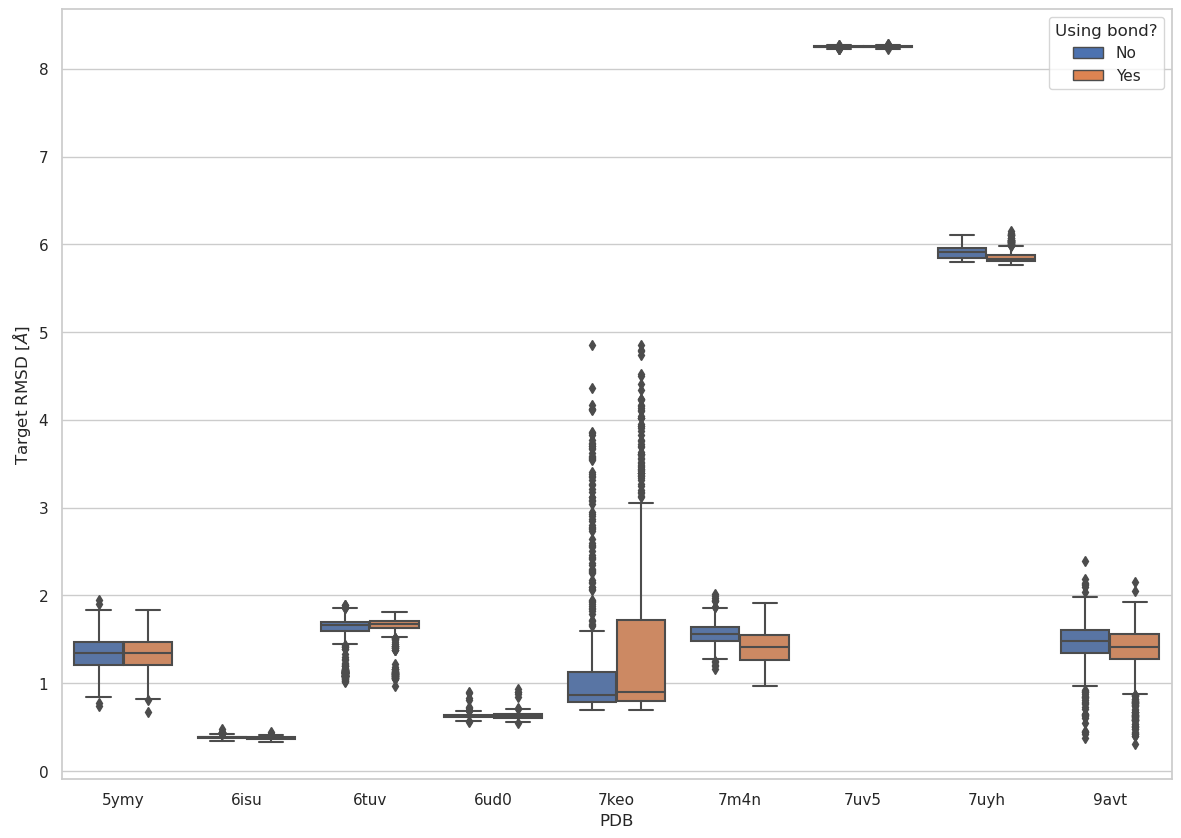

In [44]:
# Plot the distances

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn

# Get the default color palette
colors = seaborn.color_palette()

fig = plt.figure(layout="constrained")
 
# use to set style of background of plot
seaborn.set_theme(rc={'figure.figsize':(11.7,8.27)})
seaborn.set(style="whitegrid")


ax = seaborn.boxplot(x="PDB", y="RMSD", hue="bond", data=target_rmsd_df)
ax.set_ylabel(r'Target RMSD [$\AA$]')
ax.legend(title='Using bond?', labels=['No', 'Yes'])
leg = ax.get_legend()
leg.legendHandles[0].set_facecolor(colors[0])
leg.legendHandles[1].set_facecolor(colors[1])
leg.legendHandles[0].set_linewidth(1)
leg.legendHandles[1].set_linewidth(1)


plt.savefig("AF3-target-rmsd.svg", bbox_inches=0, transparent=True)
plt.savefig("AF3-target-rmsd.png", bbox_inches=0, transparent=True)

plt.show()

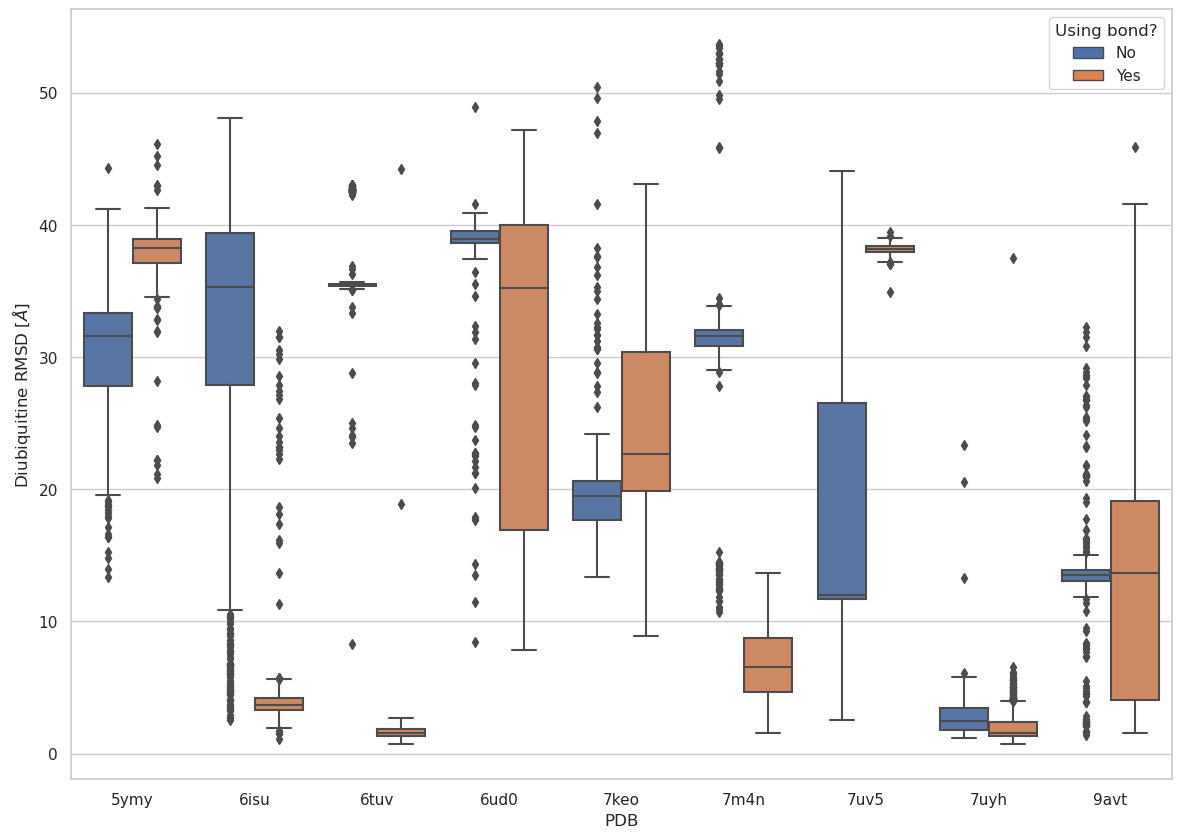

In [45]:
# Get the default color palette
colors = seaborn.color_palette()

fig = plt.figure(layout="constrained")
 
# use to set style of background of plot
seaborn.set_theme(rc={'figure.figsize':(11.7,8.27)})
seaborn.set(style="whitegrid")


ax = seaborn.boxplot(x="PDB", y="RMSD", hue="bond", data=diub_rmsd_df)
ax.set_ylabel(r'Diubiquitine RMSD [$\AA$]')
ax.legend(title='Using bond?', labels=['No', 'Yes'])
# ax.set_ylim([17.5,32.5])
leg = ax.get_legend()
leg.legendHandles[0].set_facecolor(colors[0])
leg.legendHandles[1].set_facecolor(colors[1])
leg.legendHandles[0].set_linewidth(1)
leg.legendHandles[1].set_linewidth(1)


plt.savefig("AF3-diub-rmsd.svg", bbox_inches=0, transparent=True)
plt.savefig("AF3-diub-rmsd.png", bbox_inches=0, transparent=True)

plt.show()

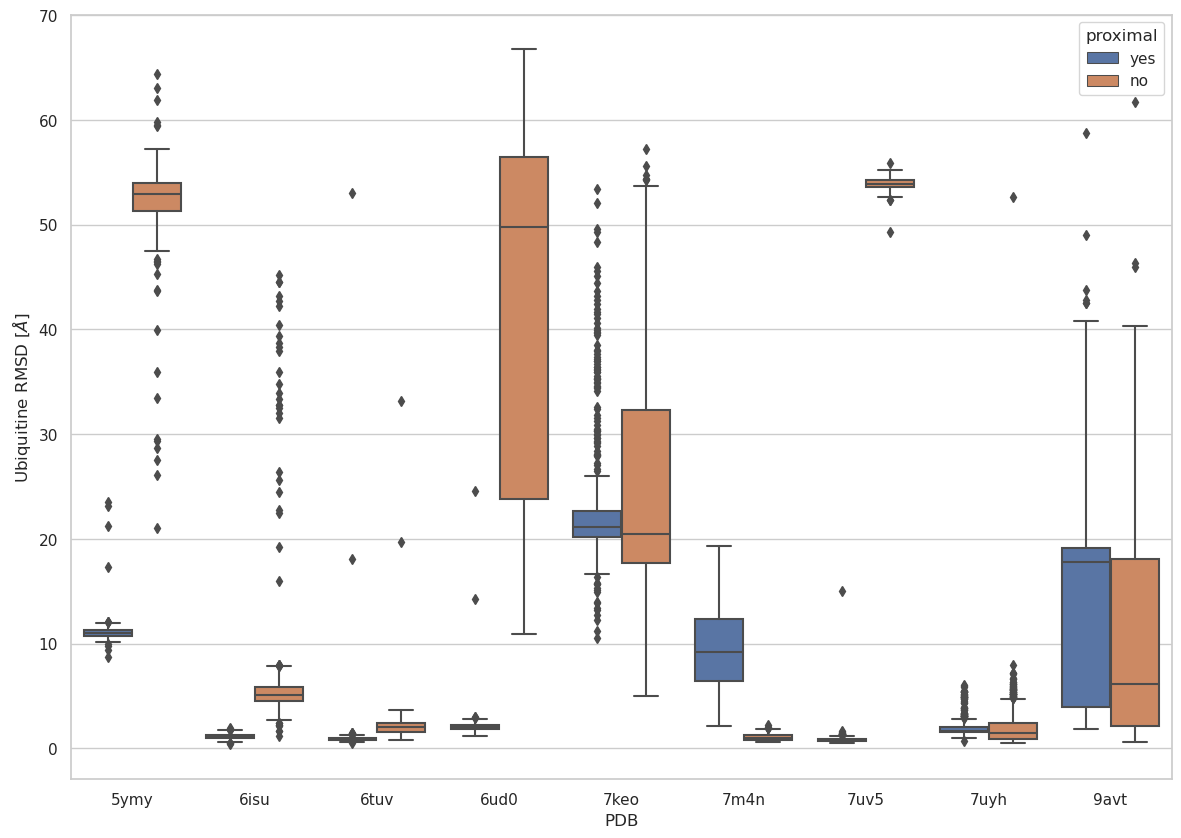

In [46]:
# Get the default color palette
colors = seaborn.color_palette()

fig = plt.figure(layout="constrained")
 
# use to set style of background of plot
seaborn.set_theme(rc={'figure.figsize':(11.7,8.27)})
seaborn.set(style="whitegrid")


ax = seaborn.boxplot(x="PDB", y="RMSD", hue="proximal", data=monoub_rmsd_df[monoub_rmsd_df['bond'] == 'yes'])
ax.set_ylabel(r'Ubiquitine RMSD [$\AA$]')
#ax.legend(title='Using bond?', labels=['No', 'Yes'])



plt.savefig("AF3-monoub-bond-rmsd.svg", bbox_inches=0, transparent=True)
plt.savefig("AF3-monoub-bond-rmsd.png", bbox_inches=0, transparent=True)

plt.show()

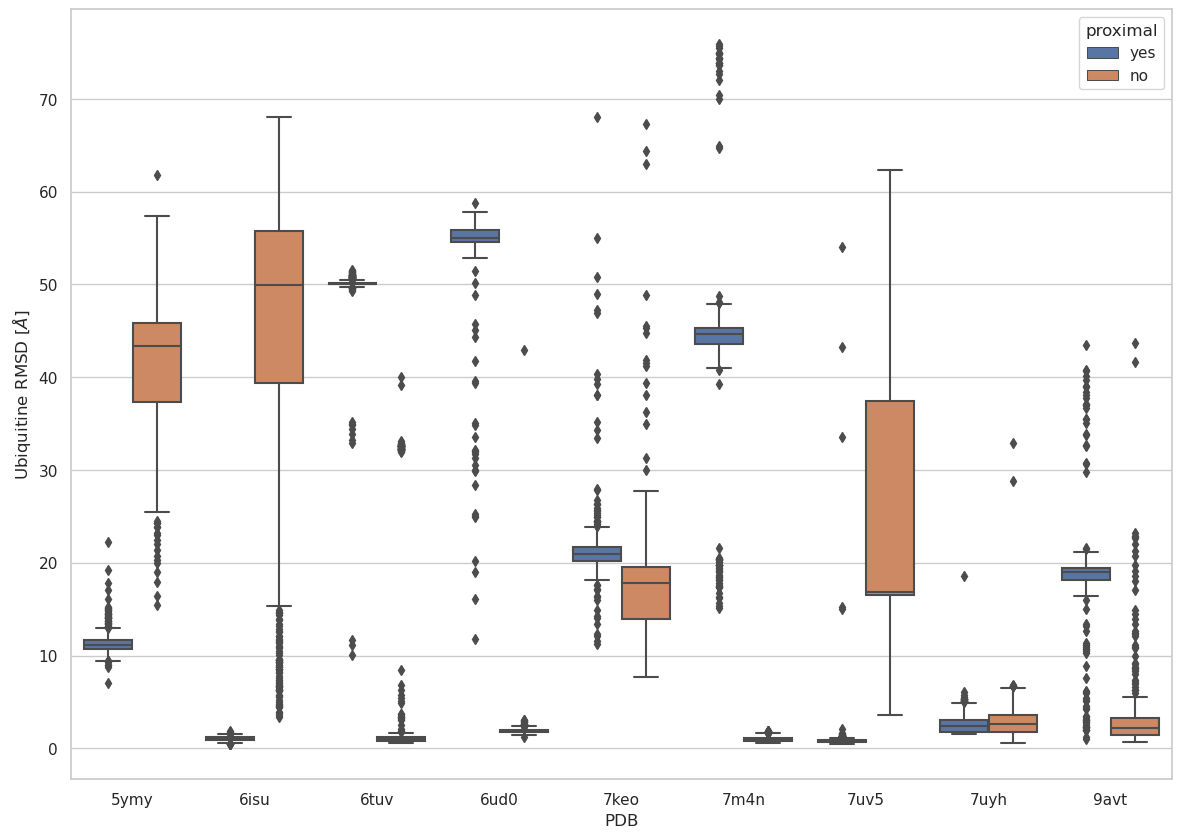

In [47]:
# Get the default color palette
colors = seaborn.color_palette()

fig = plt.figure(layout="constrained")
 
# use to set style of background of plot
seaborn.set_theme(rc={'figure.figsize':(11.7,8.27)})
seaborn.set(style="whitegrid")


ax = seaborn.boxplot(x="PDB", y="RMSD", hue="proximal", data=monoub_rmsd_df[monoub_rmsd_df['bond'] == 'no'])
ax.set_ylabel(r'Ubiquitine RMSD [$\AA$]')
#ax.legend(title='Using bond?', labels=['No', 'Yes'])



plt.savefig("AF3-monoub-rmsd.svg", bbox_inches=0, transparent=True)
plt.savefig("AF3-monoub-rmsd.png", bbox_inches=0, transparent=True)

plt.show()